# Software Defects analysis

https://www.kaggle.com/datasets/ravikumarrn/software-defects-dataset-1k

"Ravikumar R N, Software Defects Multilingual Dataset with AST Features (2025). Generated by synthetic methods for defect prediction and multilingual code analysis."
🧠 Dataset Highlights

- Languages Included: Python, Java, JavaScript, C, C++, Go, Rust
- Records: 1,000 code snippets
- Labels: defect (1 = buggy, 0 = clean)
- Features:
token_count: Total tokens (AST-based for Python)
num_ifs, num_returns, num_func_calls: Code structure features
ast_nodes: Number of nodes in the abstract syntax tree (Python only)
lines_of_code & cyclomatic_complexity: Simulated metrics for modeling

📊 Columns Description
| Column | Description |
|----------------------|-----------------------------------------------------|
| function_name | Unique identifier for the function |
| code | The actual function source code |
| language | Programming language used |
| lines_of_code | Approximate number of lines in the function |
| cyclomatic_complexity | Simulated measure of decision complexity |
| defect | 1 = buggy, 0 = clean |
| token_count | Total token count (Python uses AST tokens) |
| num_ifs | Count of 'if' statements |
| num_returns | Count of 'return' statements |
| num_func_calls | Number of function calls |
| ast_nodes | AST node count (Python only, fallback = token count) |


📎** License**
This dataset is synthetic and licensed under CC BY 4.0. Feel free to use, share, or adapt it with proper attribution.

Software Defects Multilingual Dataset with AST & Token Features (2025), un conjunto de datos sintético diseñado para el estudio de predicción de defectos en software y la análisis estático de código en múltiples lenguajes de programación.
Predecimoses entrenar modelos de machine learning capaces de predecir si una función de código contiene defectos o no, basándose en métricas estáticas (tokens, complejidad, estructuras de control, etc.).

PLANNING:
- INTRO - short dataset description.
- EDA - shape, dtypes, missing, class balance, sample rows, correlations.
- PREPARING DATA - drop useless columns, fix dtype issues, parse timestamps, coerce numerics, encode label.
- DATA SPLITTING - splitting training and testing data.
- RESULTS - early results.
- PREPARING MODELS - prepare hyperparameter, baseline models.
- RESULTS WITH MULTIPLES MODELS- metrics (precision/recall/f1), confusion matrix.
- BALANCING - try balancing and compare.
- RESULTS (after balancing) - compare metrics.
- CONCLUSION - state best model, tradeoffs, next steps.

# EDA

## Importamos las librerías necesarias y cargamos el dataset

In [ ]:
import pandas as pd
from pathlib import Path

base_dir = Path.cwd()
csv_file_path = base_dir.parent.parent / "data" / "software_defects" / "software_defects.csv"
df = pd.read_csv(csv_file_path, low_memory=False, index_col=0)
df.head(1)

,code,language,lines_of_code,cyclomatic_complexity,token_count,num_ifs,num_returns,num_func_calls,ast_nodes,defect
function_name,,,,,,,,,,
go_func_0,"func add(a int, b int) int { return a + b }",go,2,2,12,0,1,1,12,0


## Realizamos un analisis exploratorio sobre los datos

### Exploramos la forma general del dataset

In [ ]:
# Realizamos un analysis exploratorio sobre los datos
print("Shape:", df.shape)
print("\nColumns and dtypes:")
print(df.dtypes)
print("\nNumeric summary (describe):")
display(df.describe().T)

Shape: (1000, 10)

Columns and dtypes:
code                     object
language                 object
lines_of_code             int64
cyclomatic_complexity     int64
token_count               int64
num_ifs                   int64
num_returns               int64
num_func_calls            int64
ast_nodes                 int64
defect                    int64
dtype: object

Numeric summary (describe):


,count,mean,std,min,25%,50%,75%,max
lines_of_code,1000.0,3.431,1.708847,1.0,2.0,3.0,5.0,6.0
cyclomatic_complexity,1000.0,2.914,1.394471,1.0,2.0,3.0,4.0,5.0
token_count,1000.0,11.622,1.809528,9.0,11.0,12.0,12.0,18.0
num_ifs,1000.0,0.000,0.000000,0.0,0.0,0.0,0.0,0.0
num_returns,1000.0,0.856,0.351265,0.0,1.0,1.0,1.0,1.0
num_func_calls,1000.0,0.972,0.365170,0.0,1.0,1.0,1.0,2.0
ast_nodes,1000.0,11.622,1.809528,9.0,11.0,12.0,12.0,18.0
defect,1000.0,0.512,0.500106,0.0,0.0,1.0,1.0,1.0


### Verificamos valores nulos

In [ ]:
# Resumen de valores nulos

missing_counts = df.isna().sum()
missing_percent = 100 * missing_counts / len(df)
missing_summary = pd.concat([missing_counts, missing_percent], axis=1)
missing_summary.columns = ["nulos", "porcentaje"]
print("\nNulos por columna (n y %):")
display(missing_summary.sort_values("nulos", ascending=False).head(20))


Nulos por columna (n y %):


,nulos,porcentaje
code,0,0.0
language,0,0.0
lines_of_code,0,0.0
cyclomatic_complexity,0,0.0
token_count,0,0.0
num_ifs,0,0.0
num_returns,0,0.0
num_func_calls,0,0.0
ast_nodes,0,0.0
defect,0,0.0


Revisamos su distribution

Counts:
defect
1    512
0    488
Name: count, dtype: int64

Percent:
defect
1    51.2
0    48.8
Name: count, dtype: float64


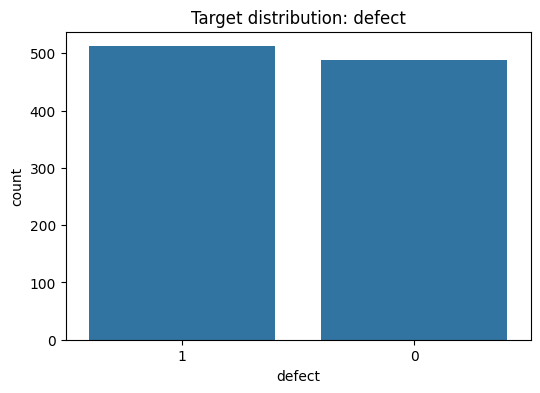

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

target_col = "defect"
figsize = (6, 4)

# Muestra los conteos y porcentajes para la variable binaria objetivo

vc = df[target_col].value_counts(dropna=False)
pct = (vc / len(df) * 100).round(2)
print("Counts:")
print(vc)
print("\nPercent:")
print(pct)

plt.figure(figsize=figsize)
sns.barplot(x=vc.index.astype(str), y=vc.values)
plt.title(f"Target distribution: {target_col}")
plt.ylabel("count")
plt.xlabel(target_col)
plt.show()

# PREPARING DATA

In [ ]:
# Hacemos una copia del DataFrame original para no modificar el raw
df_clean = df.copy()

# Eliminamos filas con valores nulos
df_clean = df_clean.dropna()

# Verificamos que no queden valores únicos
df_clean.nunique().sort_values()

# Quitamos espacios en los nombres de las columnas
df_clean.columns = df_clean.columns.str.strip()

# Analizamos el tipo de columnas en busca de columnas que no sean numéricas o apropiadas para el análisis
df_clean.keys()

Index(['code', 'language', 'lines_of_code', 'cyclomatic_complexity',
       'token_count', 'num_ifs', 'num_returns', 'num_func_calls', 'ast_nodes',
       'defect'],
      dtype='object')

In [ ]:
# Revisar columnas constantes
constant_cols = [c for c in df_clean.columns if df_clean[c].nunique() <= 1]
print("Constant columns:", constant_cols)


Constant columns: ['num_ifs']


In [ ]:
# Verificamos columna seleccionada como constante, si solo existe un valor único, no aporta información.
df_clean["num_ifs"].unique()

array([0])

In [ ]:
# Quitamos columnas constantes
df_clean = df_clean.drop(columns=constant_cols)

In [ ]:
# Revisar tipos y columnas mixtas
df_clean.dtypes.value_counts()

int64     7
object    2
Name: count, dtype: int64

In [ ]:
# Para identificar columnas no numéricas usamos:
df_clean.select_dtypes(include=['object']).columns.tolist()

['code', 'language']

revisamos columnas para identificar posibles errores

In [ ]:
df_clean["code"].head(1)

function_name
go_func_0    func add(a int, b int) int { return a + b }
Name: code, dtype: object

In [ ]:
# La columna "code" contiene información no numérica, sin embargo, puede aportar información relevante para el modelo,
# por lo que la conservaremos y la procesaremos adecuadamente al momento de preparar los datos para el modelo.
# si quisiéramos eliminarla, usaríamos:
# df_clean = df_clean.drop(columns=["code"])

In [ ]:
df_clean["language"].head(10)

function_name
go_func_0            go
python_func_1    python
c_func_2              c
cpp_func_3          cpp
cpp_func_4          cpp
c_func_5              c
go_func_6            go
rust_func_7        rust
java_func_8        java
rust_func_9        rust
Name: language, dtype: object

In [ ]:
df_clean["language"].unique()

array(['go', 'python', 'c', 'cpp', 'rust', 'java', 'javascript'],
      dtype=object)

In [ ]:
# La categoría 'language' es categórica nominal, por lo que aplicamos one-hot encoding, ya que no existe un orden entre las categorías.
# ej. Si convertimos a números enteros, el modelo podría interpretar que 2 > 1 > 0, lo cual no es correcto.
# Generamos variables dummy para la columna 'language'
languages_df = pd.get_dummies(df_clean["language"])
# Concatenamos las nuevas columnas al DataFrame original y eliminamos la columna 'language'
df_clean = pd.concat([df_clean, languages_df], axis=1)
df_clean = df_clean.drop(columns=["language"])

In [ ]:
# Reordenamos las columnas para que la variable objetivo quede al final, lo cual es una buena práctica
col = df_clean.pop("defect")
df_clean["defect"] = col

In [ ]:
# Tenemos valores boolean que para efectos prácticos pueden ser tratados como enteros 0/1 por el proceso de entrenamiento.
# Sin embargo es mejor convertirlos explícitamente a int para evitar problemas de tipo de datos en el modelo.
# Seleccionamos todas las columnas bool
bool_cols = df_clean.select_dtypes(include="bool").columns

# Convertimos a int (0/1)
df_clean[bool_cols] = df_clean[bool_cols].astype(int)

In [ ]:
# nuestro dataset limpio
df_clean.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1000 entries, go_func_0 to c_func_999
Data columns (total 15 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   code                   1000 non-null   object
 1   lines_of_code          1000 non-null   int64 
 2   cyclomatic_complexity  1000 non-null   int64 
 3   token_count            1000 non-null   int64 
 4   num_returns            1000 non-null   int64 
 5   num_func_calls         1000 non-null   int64 
 6   ast_nodes              1000 non-null   int64 
 7   c                      1000 non-null   int64 
 8   cpp                    1000 non-null   int64 
 9   go                     1000 non-null   int64 
 10  java                   1000 non-null   int64 
 11  javascript             1000 non-null   int64 
 12  python                 1000 non-null   int64 
 13  rust                   1000 non-null   int64 
 14  defect                 1000 non-null   int64 
dtypes: int64(14)

In [ ]:
df_clean.head(5)

,code,lines_of_code,cyclomatic_complexity,token_count,num_returns,num_func_calls,ast_nodes,c,cpp,go,java,javascript,python,rust,defect
function_name,,,,,,,,,,,,,,,
go_func_0,"func add(a int, b int) int { return a + b }",2,2,12,1,1,12,0,0,1,0,0,0,0,0
python_func_1,"def add(a, b): return a + b",2,5,12,1,0,12,0,0,0,0,0,1,0,0
c_func_2,"int divide(int a, int b) { return a / b; }",3,4,11,1,1,11,1,0,0,0,0,0,0,1
cpp_func_3,"int add(int a, int b) { return a + b; }",6,5,11,1,1,11,0,1,0,0,0,0,0,0
cpp_func_4,"int add(int a, int b) { return a + b; }",2,3,11,1,1,11,0,1,0,0,0,0,0,0


In [ ]:
df_clean = df_clean.reset_index(drop=True)

In [ ]:
df_clean.head(1)

,code,lines_of_code,cyclomatic_complexity,token_count,num_returns,num_func_calls,ast_nodes,c,cpp,go,java,javascript,python,rust,defect
0,"func add(a int, b int) int { return a + b }",2,2,12,1,1,12,0,0,1,0,0,0,0,0


# DATA SPLITTINGG

Separamos nuestro dataset en datos que serán usados para entrenamiento y para testing

Se consideran dos formas para proceder, si hemos eliminado la columna 'code' podemos simplemente separar los datos:

In [ ]:
# from sklearn.model_selection import train_test_split

# X = df_clean.iloc[:,:-1].values
# y = df_clean['defect'].values

# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.30, random_state=15, stratify=y)

Si hemos mantenido la columna 'code' debemos vectorizar sus datos:

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
from scipy.sparse import hstack
from scipy.sparse import csr_matrix
from sklearn.model_selection import train_test_split

df_reset = df_clean.reset_index()

# Features numéricos + one-hot languages
X_numeric = df_clean.drop(columns=["code", "defect"]).values

# Target
y = df_clean["defect"].values

# Vectorizamos la columna 'code' usando TF-IDF
vectorizer = TfidfVectorizer(analyzer='word', ngram_range=(1,3), max_features=50)
X_code = vectorizer.fit_transform(df_clean["code"])

# Combinamos las features numéricas con las features de texto vectorizadas
X_numeric_sparse = csr_matrix(X_numeric)
X_combined = hstack([X_numeric_sparse, X_code])

# Separamos en conjunto de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X_combined, y, test_size=0.3, random_state=15, stratify=y)


# RESULTS

Con todos los elementos necesarios, podemos realizar el entrenamiento y predicción sobre el conjunto de datos.

In [ ]:
# Realizamos el entrenamiento con un modelo de clasificación simple

from sklearn.neighbors import KNeighborsClassifier

clf = KNeighborsClassifier()

clf.fit(X_train, y_train)

,n_neighbors,5
,weights,'uniform'
,algorithm,'auto'
,leaf_size,30
,p,2
,metric,'minkowski'
,metric_params,None
,n_jobs,None


In [ ]:
# Realizamos la predicción sobre el conjunto de test
y_pred = clf.predict(X_test)

In [ ]:
# Verificamos los resultados obtenidos
from sklearn.metrics import classification_report

print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.79      0.84      0.81       146
           1       0.84      0.79      0.81       154

    accuracy                           0.81       300
   macro avg       0.81      0.81      0.81       300
weighted avg       0.81      0.81      0.81       300



# PREPARING MULTIPLE MODELS

Con el objetivo de encontrar el modelo que mejor se ajusta a nuestro problema configuraremos distintos modelos ajustando distintos hyperparametros.

In [ ]:
from sklearn.dummy import DummyClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report

In [ ]:
### DUMMY (baseline)

param_grid_dm = {
    'strategy': ['most_frequent', 'stratified', 'uniform']
}

scoring = 'f1'

clf_dm = GridSearchCV(DummyClassifier(), param_grid=param_grid_dm, scoring=scoring, cv=10)

In [ ]:
### DECISION TREE

param_grid_dt = {
    'criterion': ['gini', 'entropy'],
    'max_depth': [3],
    'min_samples_split': [10],
    'min_samples_leaf': [10],
    'max_features': ['sqrt'],
    'class_weight': ['balanced'],
}

scoring = 'f1'

clf_dt = GridSearchCV(DecisionTreeClassifier(), param_grid=param_grid_dt, scoring=scoring, cv=10)

In [ ]:
### RANDOM FOREST

param_grid_rf = {
    'n_estimators': [50],
    'max_depth': [3],
    'min_samples_split': [5],
    'min_samples_leaf': [10],
    'max_features': ['sqrt'],
    'criterion': ['gini', 'entropy'],
    'class_weight': ['balanced'],
}

clf_rf = GridSearchCV(RandomForestClassifier(), param_grid=param_grid_rf, scoring='f1', cv=10)

In [ ]:
### SUPPORT VECTOR CLASSIFIER

param_grid_svc = {
    'C': [1],          
    'kernel': ['rbf'],
}

clf_svc = GridSearchCV(SVC(), param_grid=param_grid_svc, scoring='f1', cv=10)

In [ ]:
### K-NEIGHBORS

param_grid_knn = {
    'n_neighbors': [3, 5, 7],
    'weights': ['uniform', 'distance'],
    'metric': ['euclidean', 'manhattan']
}

clf_knn = GridSearchCV(KNeighborsClassifier(), param_grid=param_grid_knn, scoring='f1', cv=10)

Una vez tengamos los modelos creados los agruparemos para luego iterar sobre ellos y comparar sus resultados

In [ ]:
# Agrupamos los clasificadores en un diccionario para luego iterar sobre ellos
classifiers = {
    "Base dummy": clf_dm,
    "Decision Tree": clf_dt, 
    "Random Forest": clf_rf, 
    "Support Vector Classifier": clf_svc, 
    "K-neighbors": clf_knn
}

In [ ]:
# Función para entrenar y evaluar múltiples modelos
def train_with_multiples_models(classifiers: dict, X_train, y_train, X_test, y_test):
    for name, clf in classifiers.items():
        print(':::::::::::::::::::::::::::::::::::::::::')
        print(f'Current classifier: {name}')
        print('Training..')
        clf.fit(X_train, y_train)

        print("Mejor combinación de parámetros:")
        print(clf.best_params_)
        
        y_pred = clf.predict(X_test)
        print(classification_report(y_test, y_pred, zero_division=0))

# RESULTS WITH MULTIPLE MODELS

Ya realizamos un entrenamiento y predicción utilizando un modelo, esta vez repetiremos ese proceso para todos los modelos que hemos creado.

In [ ]:
train_with_multiples_models(classifiers=classifiers, X_train=X_train, y_train=y_train, X_test=X_test, y_test=y_test)

:::::::::::::::::::::::::::::::::::::::::
Current classifier: Base dummy
Training..
Mejor combinación de parámetros:
{'strategy': 'most_frequent'}
              precision    recall  f1-score   support

           0       0.00      0.00      0.00       146
           1       0.51      1.00      0.68       154

    accuracy                           0.51       300
   macro avg       0.26      0.50      0.34       300
weighted avg       0.26      0.51      0.35       300

:::::::::::::::::::::::::::::::::::::::::
Current classifier: Decision Tree
Training..


Mejor combinación de parámetros:
{'class_weight': 'balanced', 'criterion': 'entropy', 'max_depth': 3, 'max_features': 'sqrt', 'min_samples_leaf': 10, 'min_samples_split': 10}
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       146
           1       1.00      1.00      1.00       154

    accuracy                           1.00       300
   macro avg       1.00      1.00      1.00       300
weighted avg       1.00      1.00      1.00       300

:::::::::::::::::::::::::::::::::::::::::
Current classifier: Random Forest
Training..
Mejor combinación de parámetros:
{'class_weight': 'balanced', 'criterion': 'gini', 'max_depth': 3, 'max_features': 'sqrt', 'min_samples_leaf': 10, 'min_samples_split': 5, 'n_estimators': 50}
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       146
           1       1.00      1.00      1.00       154

    accuracy                           1.00       300
  

# BALANCING

In [ ]:
# Verificamos la distribución de la variable objetivo en el dataset limpio
df_clean['defect'].value_counts()

defect
1    512
0    488
Name: count, dtype: int64

### UNDERSAMPLE

In [ ]:

from imblearn.under_sampling import RandomUnderSampler

rus = RandomUnderSampler(random_state=42)
X_resampled, y_resampled = rus.fit_resample(X_train, y_train)

print("Balanced class distribution (undersampling):")
print(pd.Series(y_resampled).value_counts())

Balanced class distribution (undersampling):
0    342
1    342
Name: count, dtype: int64


In [ ]:
train_with_multiples_models(classifiers=classifiers, X_train=X_resampled, y_train=y_resampled, X_test=X_test, y_test=y_test)

:::::::::::::::::::::::::::::::::::::::::
Current classifier: Base dummy
Training..
Mejor combinación de parámetros:
{'strategy': 'stratified'}
              precision    recall  f1-score   support

           0       0.49      0.55      0.52       146
           1       0.52      0.45      0.48       154

    accuracy                           0.50       300
   macro avg       0.50      0.50      0.50       300
weighted avg       0.51      0.50      0.50       300

:::::::::::::::::::::::::::::::::::::::::
Current classifier: Decision Tree
Training..
Mejor combinación de parámetros:
{'class_weight': 'balanced', 'criterion': 'entropy', 'max_depth': 3, 'max_features': 'sqrt', 'min_samples_leaf': 10, 'min_samples_split': 10}
              precision    recall  f1-score   support

           0       0.84      1.00      0.91       146
           1       1.00      0.82      0.90       154

    accuracy                           0.91       300
   macro avg       0.92      0.91      0.91      

In [ ]:
from imblearn.over_sampling import RandomOverSampler

ros = RandomOverSampler(random_state=42)
X_resampled, y_resampled = ros.fit_resample(X_train, y_train)

print("Balanced class distribution (oversampling):")
print(pd.Series(y_resampled).value_counts())

Balanced class distribution (oversampling):
0    358
1    358
Name: count, dtype: int64


In [ ]:
train_with_multiples_models(classifiers=classifiers, X_train=X_resampled, y_train=y_resampled, X_test=X_test, y_test=y_test)

:::::::::::::::::::::::::::::::::::::::::
Current classifier: Base dummy
Training..
Mejor combinación de parámetros:
{'strategy': 'stratified'}
              precision    recall  f1-score   support

           0       0.49      0.47      0.48       146
           1       0.52      0.53      0.52       154

    accuracy                           0.50       300
   macro avg       0.50      0.50      0.50       300
weighted avg       0.50      0.50      0.50       300

:::::::::::::::::::::::::::::::::::::::::
Current classifier: Decision Tree
Training..
Mejor combinación de parámetros:
{'class_weight': 'balanced', 'criterion': 'entropy', 'max_depth': 3, 'max_features': 'sqrt', 'min_samples_leaf': 10, 'min_samples_split': 10}
              precision    recall  f1-score   support

           0       1.00      0.80      0.89       146
           1       0.84      1.00      0.91       154

    accuracy                           0.90       300
   macro avg       0.92      0.90      0.90      

# CONCLUSION

- Overfitting: Random Forest y KNN memorizaron todas las funciones ~ accuracy 1.0.
    Ocurre por: dataset pequeño, TF-IDF incluso con 50 features + métricas numéricas + one-hot.

- Decision Tree y SVC
    Limitando max_depth y min_samples_leaf, los modelos muestran desempeño más realista (F1 ~0.83–0.86).
    Estos modelos empiezan a capturar patrones generales en lugar de memorizar cada función.

- TF-IDF + numeric features
    TF-IDF de 50 features es suficiente para añadir señal textual sin permitir memorization total.
    Features numéricas + one-hot de lenguaje aportan información estructural relevante.

En definitiva, el conjunto de datos es muy pequeño para obtener estimaciones robustas. Se observa que la columna code contiene información potencialmente valiosa, pero la forma actual en que se procesa (TF-IDF con pocas features o sin embeddings más sofisticados) limita la capacidad de los modelos para generalizar.

Si se obvia la columna code y se usan solo métricas numéricas y el lenguaje del código, los resultados no son suficientemente decisivos para identificar patrones de defectos con confianza. Por lo tanto, se plantea una reestructuración o enriquecimiento de la información de la columna code (por ejemplo, mediante embeddings, extracción de features sintácticas o semánticas más avanzadas) para mejorar el desempeño predictivo y la fiabilidad de los modelos.